# 4. Análise de centralidade e comunidades no grafo de autoria



## 4.1. Preparação



### 4.1.1. Imports

In [96]:

import os

from pathlib import Path
from collections import defaultdict
import itertools
# import duckdb
import numpy as np
import pandas as pd
import igraph as ig

from event import Event

from dotenv import load_dotenv

load_dotenv()
pd.set_option('display.max_rows', 20)

PROJECT_DIR = Path("~/tramita").expanduser()
DB_PATH = PROJECT_DIR / os.getenv("SILVER_DUCKDB_PATH", "")
OUT_DIR = PROJECT_DIR / "gold" / "outputs"
OUT_DIR.mkdir(exist_ok=True)
ACCESS_DIR = PROJECT_DIR / "gold" / "accessory_data"
ACCESS_DIR.mkdir(exist_ok=True)

NODES_PATH_PARQUET = OUT_DIR / "nodes.parquet"
EDGES_PATH_PARQUET = OUT_DIR / "edges.parquet"
NODES_PATH_CSV = OUT_DIR / "nodes.csv"
EDGES_PATH_CSV = OUT_DIR / "edges.csv"

# with duckdb.connect(DB_PATH, read_only=True) as con:

COLLAB_NODES_CSV = OUT_DIR / "nodes_collab.csv"
COLLAB_EDGES_CSV = OUT_DIR / "edges_collab.csv"

### 4.1.2. Funções auxiliares

In [97]:
def merge_nodes(nodes_df: pd.DataFrame, edges_df: pd.DataFrame, taglist: list[str]) -> None:
    """Merges the indicated nodes and consolidates the respective edges."""
    surviving_tag = taglist[0]
    for removed_tag in taglist[1:]:
        edges_df.loc[edges_df['source'] == removed_tag, 'source'] = surviving_tag
        edges_df.loc[edges_df['target'] == removed_tag, 'target'] = surviving_tag

    nodes_df.drop(index=taglist[1:], inplace=True)
    

def prune_graph(
    node_df: pd.DataFrame,
    edge_df: pd.DataFrame,
    tag_col: str = "name",
    from_col: str = "from",
    to_col: str = "to",
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Removes any orphan nodes, then edges, until every node has degree at least 1."""
    def _prune_nodes(node_df: pd.DataFrame, edge_df: pd.DataFrame) -> pd.DataFrame:
        return node_df[
            (node_df[tag_col].isin(edge_df[from_col]))
            | (node_df[tag_col].isin(edge_df[to_col]))
        ]
        
        
    def _prune_edges(node_df: pd.DataFrame, edge_df: pd.DataFrame) -> pd.DataFrame:
        return edge_df[
            (edge_df[from_col].isin(node_df[tag_col]))
            & (edge_df[to_col].isin(node_df[tag_col]))
        ]

    while True:
        n = len(node_df)
        m = len(edge_df)
        node_df = _prune_nodes(node_df, edge_df)
        edge_df = _prune_edges(node_df, edge_df)
        if n == len(node_df) and m == len(edge_df):
            return node_df, edge_df
        
def build_graph(node_df: pd.DataFrame, edge_df: pd.DataFrame) -> ig.Graph:
    """
    Builds an igraph.Graph from a node and edge list.
    The node DataFrame must have a 'name' column with the unique identifiers.
    The edge DataFrame must have 'from' and 'to' columns.
    Any other columns will be absorbed as attributes.
    """
    edge_tuples = list(zip(edge_df['from'], edge_df['to']))
    g = ig.Graph.TupleList(
        edge_tuples,
        directed=False,
        vertex_name_attr="name",
        weights=True,
    )
    for col in node_df.columns:
        if col != "name":
            g.vs[col] = node_df.set_index("name").loc[g.vs['name'], col].tolist()

    for col in edge_df.columns:
        if col not in ("from", "to"):
            g.es[col] = edge_df[col].tolist()
    
    return g


## 4.2. Qualificação de arestas de autoria de acordo com o estágio de tramitação no Congresso



### 4.2.1. Carga dos dados

In [98]:
event_df = pd.read_pickle(ACCESS_DIR / "full_event_df.pkl")
edges_df = pd.read_parquet(EDGES_PATH_PARQUET)
nodes_df = pd.read_parquet(NODES_PATH_PARQUET)

### 4.2.1. Definição da casa inicial de tramitação de cada proposição

Proposições protocoladas por senadores iniciam a tramitação no Senado; as demais, na Câmara.

In [99]:
# agregamos as autorias aos eventos

event_labeled_df = event_df.join(
    edges_df[edges_df['etype'] == 'autoria'].set_index('target')[['source']], on="prop_tag"
).rename(columns={'source': 'auth_camara_tag'}).join(
    edges_df[edges_df['etype'] == 'autoria'].set_index('target')[['source']], on="proc_tag"
).rename(columns={'source': 'auth_senado_tag'}).join(
    nodes_df.set_index('tag')[['label']], on="auth_camara_tag", rsuffix="_auth"
).rename(columns={'label_auth': 'auth_camara_label'}).join(
    nodes_df.set_index('tag')[['label']], on="auth_senado_tag", rsuffix="_auth"
).rename(columns={'label_auth': 'auth_senado_label'})
event_labeled_df

,label,event_ts,event,event_loc,casa,prop_tag,proc_tag,auth_camara_tag,auth_senado_tag,auth_camara_label,auth_senado_label
0,MPV 1000/2020,2020-09-03 00:00:00,Event.APRESENTADO,SF,senado,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA
1,MPV 1000/2020,2020-09-03 10:57:00,Event.APRESENTADO,EXEC,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA
2,MPV 1000/2020,2020-09-09 00:00:00,Event.RECEBIDO_COMISSAO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA
3,MPV 1000/2020,2020-09-09 00:00:00,Event.APRESENTADO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA
4,MPV 1000/2020,2020-09-10 12:09:00,Event.DISTRIBUIDO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA
...,...,...,...,...,...,...,...,...,...,...,...
114703,PLV 8/2023,2023-03-30 17:23:00,Event.APRESENTADO,MPV115222,camara,CP:2354532,NaN,CD:204355,NaN,JOSIAS MARIO DA VITORIA,NaN
114704,PLV 9/2020,2020-04-29 22:15:00,Event.APRESENTADO,PLEN,camara,CP:2250966,NaN,CD:141531,NaN,RODRIGO BATISTA DE CASTRO,NaN
114705,PLV 9/2021,2021-05-25 19:23:00,Event.APRESENTADO,PLEN,camara,CP:2284649,NaN,CD:204569,NaN,PABLO OLIVA SOUZA,NaN
114706,PLV 9/2022,2022-05-11 17:23:00,Event.APRESENTADO,MPV108021,camara,CP:2322707,NaN,CD:178881,NaN,ALUISIO GUIMARAES MENDES FILHO,NaN


In [100]:
# como agora temos uma fileira para cada autor, vamos manter apenas o primeiro (só precisamos saber de onde sai cada projeto)

event_labeled_df = event_labeled_df[event_labeled_df[['label', 'event_ts', 'event', 'event_loc']].ne(
    event_labeled_df[['label', 'event_ts', 'event', 'event_loc']].shift()
).any(axis=1)].reset_index(drop=True)
event_labeled_df

,label,event_ts,event,event_loc,casa,prop_tag,proc_tag,auth_camara_tag,auth_senado_tag,auth_camara_label,auth_senado_label
0,MPV 1000/2020,2020-09-03 00:00:00,Event.APRESENTADO,SF,senado,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA
1,MPV 1000/2020,2020-09-03 10:57:00,Event.APRESENTADO,EXEC,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA
2,MPV 1000/2020,2020-09-09 00:00:00,Event.RECEBIDO_COMISSAO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA
3,MPV 1000/2020,2020-09-09 00:00:00,Event.APRESENTADO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA
4,MPV 1000/2020,2020-09-10 12:09:00,Event.DISTRIBUIDO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA
...,...,...,...,...,...,...,...,...,...,...,...
114806,PLV 8/2023,2023-03-30 17:23:00,Event.APRESENTADO,MPV115222,camara,CP:2354532,NaN,CD:204355,NaN,JOSIAS MARIO DA VITORIA,NaN
114807,PLV 9/2020,2020-04-29 22:15:00,Event.APRESENTADO,PLEN,camara,CP:2250966,NaN,CD:141531,NaN,RODRIGO BATISTA DE CASTRO,NaN
114808,PLV 9/2021,2021-05-25 19:23:00,Event.APRESENTADO,PLEN,camara,CP:2284649,NaN,CD:204569,NaN,PABLO OLIVA SOUZA,NaN
114809,PLV 9/2022,2022-05-11 17:23:00,Event.APRESENTADO,MPV108021,camara,CP:2322707,NaN,CD:178881,NaN,ALUISIO GUIMARAES MENDES FILHO,NaN


In [101]:
for col in event_labeled_df.columns:
    if col.endswith("_tag"):
        event_labeled_df[col] = event_labeled_df[col].str.strip().str.upper()

event_labeled_df = event_labeled_df.fillna('')

Processo vetorizado para definição da origem

In [102]:
from_camara = (
    event_labeled_df['auth_camara_tag'].str.startswith("CD:")
    | (event_labeled_df['auth_senado_tag'] == "SE:2")
    | (event_labeled_df['auth_camara_tag'].isin([
        "CO:5438",  # Comissão de Legislação Participativa
        "CO:2003",  # CCJC
        "CO:539426",  # CPI da Americanas
    ]))
    | (event_labeled_df['auth_camara_label'].str.startswith("Comissão Mista da MPV"))  # Todas começam na Câmara
)
from_senado = (
    event_labeled_df['auth_senado_tag'].str.startswith("SS:")
    | (event_labeled_df['auth_camara_tag'].isin([
        "CO:78",  # Senado
        "CO:79",  # Comissão mista (na verdade o autor é o Sen. Jorginho Mello)
    ]))
    | (event_labeled_df['auth_senado_tag'].isin([
        "SE:7352398",  # CPI da Pandemia
        "SE:3947422",  # Comissão de direitos humanos do Senado 
    ]))
)
from_externo = ~(from_camara | from_senado)

event_labeled_df['origem'] = np.select(
    [from_camara, from_senado, from_externo],
    ['camara', 'senado', 'externo'],
    default='unknown'
)
event_labeled_df

,label,event_ts,event,event_loc,casa,prop_tag,proc_tag,auth_camara_tag,auth_senado_tag,auth_camara_label,auth_senado_label,origem
0,MPV 1000/2020,2020-09-03 00:00:00,Event.APRESENTADO,SF,senado,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA,externo
1,MPV 1000/2020,2020-09-03 10:57:00,Event.APRESENTADO,EXEC,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA,externo
2,MPV 1000/2020,2020-09-09 00:00:00,Event.RECEBIDO_COMISSAO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA,externo
3,MPV 1000/2020,2020-09-09 00:00:00,Event.APRESENTADO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA,externo
4,MPV 1000/2020,2020-09-10 12:09:00,Event.DISTRIBUIDO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA,externo
...,...,...,...,...,...,...,...,...,...,...,...,...
114806,PLV 8/2023,2023-03-30 17:23:00,Event.APRESENTADO,MPV115222,camara,CP:2354532,,CD:204355,,JOSIAS MARIO DA VITORIA,,camara
114807,PLV 9/2020,2020-04-29 22:15:00,Event.APRESENTADO,PLEN,camara,CP:2250966,,CD:141531,,RODRIGO BATISTA DE CASTRO,,camara
114808,PLV 9/2021,2021-05-25 19:23:00,Event.APRESENTADO,PLEN,camara,CP:2284649,,CD:204569,,PABLO OLIVA SOUZA,,camara
114809,PLV 9/2022,2022-05-11 17:23:00,Event.APRESENTADO,MPV108021,camara,CP:2322707,,CD:178881,,ALUISIO GUIMARAES MENDES FILHO,,camara


In [103]:
event_origin_df = event_df.join(event_labeled_df[['label', 'origem']].drop_duplicates().set_index('label', drop=True), how='left', on='label')
event_origin_df.to_pickle(ACCESS_DIR / "event_origin_df.pkl")

### 4.2.2. Atribuição de notas referentes ao progresso de proposições

Critérios para score de proposições:

(considerando que o caminho pode ser Câmara -> Senado ou Senado -> Câmara)

* Foi protocolada na primeira casa mas não chegou a comissão ou plenário: 0.0
* Chegou a comissão ou plenário na primeira casa: 0.25
* Aprovada na primeira casa: 0.5
* Chegou a comissão ou plenário na segunda casa: 0.75
* Aprovada na segunda casa (ou seja, remetida a sanção ou promulgação): 1.0

In [104]:
df = event_labeled_df
by_label = df.groupby('label', sort=False)
origem = by_label['origem'].first()
origem

label
MPV 1000/2020    externo
MPV 1001/2020    externo
MPV 1002/2020    externo
MPV 1003/2020    externo
MPV 1004/2020    externo
                  ...   
PLV 8/2023        camara
PLV 9/2020        camara
PLV 9/2021        camara
PLV 9/2022        camara
PLV 9/2023       externo
Name: origem, Length: 28081, dtype: object

In [105]:
is_mpv_pl = df['label'].str.startswith(('MPV','PL'))
is_pec = df['label'].str.startswith('PEC')
has_sancao = df['event'].eq(Event.REMETIDO_A_SANCAO).groupby(df['label']).any()
has_promulg = df['event'].eq(Event.REMETIDO_A_PROMULGACAO).groupby(df['label']).any()

In [106]:
presence = (
    df.assign(present=True).pivot_table(
        index='label',
        columns=['casa','event'],
        values='present',
        aggfunc='any',
        fill_value=False
    )
)
presence

casa                     camara                                            \
event         Event.APRESENTADO Event.DISTRIBUIDO Event.RECEBIDO_COMISSAO   
label                                                                       
MPV 1000/2020              True              True                    True   
MPV 1001/2020              True              True                    True   
MPV 1002/2020              True              True                    True   
MPV 1003/2020              True              True                    True   
MPV 1004/2020              True              True                    True   
...                         ...               ...                     ...   
PLV 8/2023                 True             False                   False   
PLV 9/2020                 True             False                   False   
PLV 9/2021                 True             False                   False   
PLV 9/2022                 True             False                   False   
PLV 9/2023                 True             False                   False   

casa                                                                          \
event         Event.DESIGNADO_RELATOR_COMISSAO Event.RETIRADO_PAUTA_COMISSAO   
label                                                                          
MPV 1000/2020                            False                         False   
MPV 1001/2020                            False                         False   
MPV 1002/2020                            False                         False   
MPV 1003/2020                            False                         False   
MPV 1004/2020                            False                         False   
...                                        ...                           ...   
PLV 8/2023                               False                         False   
PLV 9/2020                               False                         False   
PLV 9/2021                               False                         False   
PLV 9/2022                               False                         False   
PLV 9/2023                               False                         False   

casa                                                                    \
event         Event.APROVADA_URGENCIA Event.DESIGNADO_RELATOR_PLENARIO   
label                                                                    
MPV 1000/2020                   False                             True   
MPV 1001/2020                   False                            False   
MPV 1002/2020                   False                            False   
MPV 1003/2020                   False                             True   
MPV 1004/2020                   False                             True   
...                               ...                              ...   
PLV 8/2023                      False                            False   
PLV 9/2020                      False                            False   
PLV 9/2021                      False                            False   
PLV 9/2022                      False                            False   
PLV 9/2023                      False                            False   

casa                                                            \
event         Event.REMETIDO_AO_SENADO Event.REMETIDO_A_SANCAO   
label                                                            
MPV 1000/2020                    False                   False   
MPV 1001/2020                    False                   False   
MPV 1002/2020                    False                   False   
MPV 1003/2020                     True                   False   
MPV 1004/2020                     True                   False   
...                                ...                     ...   
PLV 8/2023                       False                   False   
PLV 9/2020                       False                   False   
PLV 9/2021                       Fals

In [107]:
# função auxiliar para retornar a coluna de presença de um evento numa casa
def P(house: str, event: Event) -> pd.Series:
    col = (house, event)
    return (
        presence[col]
        if col in presence.columns
        else pd.Series(False, index=presence.index)
    )

In [108]:
score_camara_externo = np.select(
    [
        (is_mpv_pl.groupby(df['label']).any() & has_sancao) |
        (is_pec.groupby(df['label']).any() & has_promulg),  # 1.0
        P('senado', Event.RECEBIDO_COMISSAO) | P('senado', Event.APROVADA_URGENCIA) | P('senado', Event.DESIGNADO_RELATOR_PLENARIO),  # 0.75
        P('camara', Event.APROVADO_PLENARIO),  # 0.5
        P('camara', Event.RECEBIDO_COMISSAO) | P('camara', Event.APROVADA_URGENCIA) | P('camara', Event.DESIGNADO_RELATOR_PLENARIO),  # 0.25
    ],
    [1.0, 0.75, 0.50, 0.25],
    default=0.0
)

In [109]:
score_senado = np.select(
    [
        (is_mpv_pl.groupby(df['label']).any() & has_sancao) |
        (is_pec.groupby(df['label']).any() & has_promulg),  # 1.0
        P('camara', Event.RECEBIDO_COMISSAO) | P('camara', Event.APROVADA_URGENCIA) | P('camara', Event.DESIGNADO_RELATOR_PLENARIO),  # 0.75
        P('senado', Event.APROVADO_PLENARIO),  # 0.5
        P('senado', Event.RECEBIDO_COMISSAO) | P('senado', Event.APROVADA_URGENCIA) | P('senado', Event.DESIGNADO_RELATOR_PLENARIO),  # 0.25
    ],
    [1.0, 0.75, 0.50, 0.25],
    default=0.0
)

In [110]:
scores = pd.DataFrame({
    'origem': origem,
    'score_camara_externo': score_camara_externo,
    'score_senado': score_senado,
})
scores['score'] = np.where(
    scores['origem'].isin(['camara','externo']),
    scores['score_camara_externo'],
    np.where(scores['origem'].eq('senado'), scores['score_senado'], np.nan)
)

In [111]:
labels_and_scores: list[dict] = (
    scores['score']
    .rename('score')
    .to_frame()
    .reset_index(names='label')
    .to_dict('records')
)

In [112]:
# Proposições por rótulo e score
labels_and_scores_df = pd.DataFrame(labels_and_scores).set_index('label', drop=True)
labels_and_scores_df

,score
label,
MPV 1000/2020,0.25
MPV 1001/2020,0.25
MPV 1002/2020,0.25
MPV 1003/2020,0.75
MPV 1004/2020,0.75
...,...
PLV 8/2023,0.00
PLV 9/2020,0.00
PLV 9/2021,0.00


In [113]:
# Agregamos os scores à tabela de vértices
nodes_scored_df = nodes_df.join(labels_and_scores_df, on="label")
nodes_scored_df = nodes_scored_df.set_index('tag', drop=True)
nodes_scored_df.loc[nodes_scored_df['type'].isin(['Proposicao', 'Processo']) & nodes_scored_df['score'].isna(), 'score'] = 0.0
nodes_scored_df

,label,partido,type,score
tag,,,,
CP:2187087,PL 5029/2019,None,Proposicao,1.00
CP:2190408,PL 2/2019,None,Proposicao,0.25
CP:2190417,PL 10/2019,None,Proposicao,0.25
CP:2190423,PL 15/2019,None,Proposicao,0.00
CP:2190450,PL 21/2019,None,Proposicao,0.25
...,...,...,...,...
SE:55143,TRIBUNAL DE JUSTIÇA DO DISTRITO FEDERAL E TERR...,None,Ente,NaN
SE:9999990,SUPERIOR TRIBUNAL DE JUSTIÇA,None,Ente,NaN
SE:9999991,PROCURADORIA-GERAL DA REPÚBLICA,None,Ente,NaN


## 4.3. Preparação do grafo para análise



### 4.3.1. Fusão de arestas de correspondência

Na etapa anterior, definimos arestas do tipo 'correspondência' para proposições, parlamentares, ou entidades que eram representados por vértices múltiplos. Aqui vamos fundir esses vértices e eliminar as arestas de correspondência.

In [114]:
# Primeiro determinamos os componentes conexos de correspondência para fusão

ccs: dict[str, set] = defaultdict(set)

match_not_congresspeople_mask = (
    edges_df['etype'].eq('correspondencia')
        & ~edges_df['source'].str.startswith("SS")
        & ~edges_df['source'].str.startswith("CD")  # congresspeople require a different treatment
    )

for index, row in edges_df[match_not_congresspeople_mask].iterrows():
    src = row['source']
    tgt = row['target']
    src_set = ccs[src]
    tgt_set = ccs[tgt]
    new_set = {src, tgt}
    if not src_set and not tgt_set:
        ccs[src] = new_set
        ccs[tgt] = new_set
    elif not src_set:
        tgt_set.update(new_set)    
        ccs[src] = tgt_set
    else:  # no tgt_set
        src_set.update(new_set)
        ccs[tgt] = src_set
    
unique_ccs = {frozenset(s) for s in ccs.values()}

In [115]:
# for congresspeople, we preserve the order (source survives, target is removed)
unique_ccs = [list(s) for s in unique_ccs]

match_congresspeople_mask = (
    edges_df['etype'].eq('correspondencia')
        & (
            edges_df['source'].str.startswith("SS")
            | edges_df['source'].str.startswith("CD")
        )  # congresspeople require a different treatment
    )

unique_ccs = [sorted(s) for s in unique_ccs]

for index, row in edges_df[match_congresspeople_mask].iterrows():
    unique_ccs.append([
        row['source'], row['target'],
    ])
    
nodes_to_merge = unique_ccs

In [116]:
# Agora fazemos a fusão, eliminando as arestas de correspondência

edges_auth_df = edges_df[edges_df['etype'].eq('autoria')].drop(['etype'], axis=1).copy()


for taglist in nodes_to_merge:
    merge_nodes(nodes_scored_df, edges_auth_df, taglist)

In [117]:
print(f"Number of edges: {edges_auth_df.shape[0]}")
edges_auth_df = edges_auth_df.drop_duplicates(['source', 'target'], ignore_index=True)
print(f"Number of edges after deduplication: {edges_auth_df.shape[0]}")

Number of edges: 49842
Number of edges after deduplication: 49208


### 4.3.2. Atribuição do score às arestas de autoria e preparação dos DataFrames para ingestão no iGraph

In [118]:
edges_weighted_df = edges_auth_df.join(nodes_scored_df[['score']], on="target").rename(columns={'score': 'weight'})

edge_df = edges_weighted_df.rename(columns={'source': 'from', 'target': 'to'})
node_df = nodes_scored_df.reset_index().rename(columns={'tag': 'name'})

node_df, edge_df = prune_graph(node_df, edge_df)

In [119]:
# Finalmente, a partir deste ponto não existe mais diferença entre um órgão ou ente (nomes diferentes para a mesma coisa)
node_df.loc[node_df['type'] == "Ente", 'type'] = 'Orgao'

In [120]:
node_df.value_counts('type')

type
Proposicao    27046
Processo       1113
Deputado        903
Senador         127
Orgao            46
Name: count, dtype: int64

### 4.3.3. Colunas auxiliares

In [121]:
# definimos um tipo genérico para facilitar análise do grafo bipartite

type_to_bigtype = {
    'Proposicao': 'bill',
    'Processo': 'bill',
    'Orgao': 'author',
    'Deputado': 'author',
    'Senador': 'author',
}

node_df['bigtype'] = node_df['type'].map(type_to_bigtype)
node_df.value_counts('bigtype')

bigtype
bill      28159
author     1076
Name: count, dtype: int64

In [122]:
# Definimos uma coluna para o tipo de projeto de lei (PL, PLP, PEC...)
node_df['billtype'] = node_df.apply(
    lambda row: row['label'].split()[0] if row['bigtype'] == 'bill' else None,
    axis=1 
)
node_df

,name,label,partido,type,score,bigtype,billtype
0,CP:2187087,PL 5029/2019,None,Proposicao,1.00,bill,PL
1,CP:2190408,PL 2/2019,None,Proposicao,0.25,bill,PL
2,CP:2190417,PL 10/2019,None,Proposicao,0.25,bill,PL
3,CP:2190423,PL 15/2019,None,Proposicao,0.00,bill,PL
4,CP:2190450,PL 21/2019,None,Proposicao,0.25,bill,PL
...,...,...,...,...,...,...,...
29230,SE:7352398,CPI DA PANDEMIA,None,Orgao,NaN,author,None
29231,SE:55226,COMISSÃO DIRETORA,None,Orgao,NaN,author,None
29232,SE:3947422,COMISSÃO DE DIREITOS HUMANOS E LEGISLAÇÃO PART...,None,Orgao,NaN,author,None
29233,SE:3927825,COMISSÃO DE MEIO AMBIENTE,None,Orgao,NaN,author,None


In [123]:
# Separamos o partido da UF dos parlamentares
node_df['partido'] = node_df['partido'].str.replace("S/Partido", "Sem Partido")


In [124]:
node_df[['cod_partido', 'uf']] = node_df[node_df['partido'].notna()]['partido'].str.split("/", expand=True)

In [125]:
# preenchemos todos os NAs

node_df.isna().any()

name           False
label          False
partido         True
type           False
score           True
bigtype        False
billtype        True
cod_partido     True
uf              True
dtype: bool

In [126]:
for col in ('partido', 'billtype', 'uf'):
    node_df[col] = node_df[col].astype("string").fillna("")
    
node_df['cod_partido'] = node_df['cod_partido'].astype("string").fillna("not_applicable")

In [127]:
node_df['cod_partido'].unique()

<StringArray>
['not_applicable',             'PP',           'PSDB',            'PDT',
             'PT',          'UNIÃO',             'PL',            'PRB',
            'PSB',            'PSD',          'PCdoB',  'SOLIDARIEDADE',
            'MDB',      'CIDADANIA',           'REDE',       'PATRIOTA',
            'PSL',           'PODE',            'DEM',         'AVANTE',
             'PR',            'PSC',   'REPUBLICANOS',           'NOVO',
           'PSOL',             'PV',           'PMDB',           'PROS',
          'PATRI',            'PHS',            'PPS',            'UDN',
           'PP**',            'PTB',        'PODEMOS',    'Sem Partido']
Length: 36, dtype: string

In [128]:
# Esse "PP**" é do Vilson Covatti, que ainda é membro do partido, então não sei o que isso representa.
node_df['cod_partido'] = node_df['cod_partido'].str.rstrip("*")
node_df['cod_partido'] = node_df['cod_partido'].str.replace("PODEMOS", "PODE")
node_df['cod_partido'] = node_df['cod_partido'].str.replace("PATRIOTA", "PATRI")

node_df['cod_partido'].unique()

<StringArray>
['not_applicable',             'PP',           'PSDB',            'PDT',
             'PT',          'UNIÃO',             'PL',            'PRB',
            'PSB',            'PSD',          'PCdoB',  'SOLIDARIEDADE',
            'MDB',      'CIDADANIA',           'REDE',          'PATRI',
            'PSL',           'PODE',            'DEM',         'AVANTE',
             'PR',            'PSC',   'REPUBLICANOS',           'NOVO',
           'PSOL',             'PV',           'PMDB',           'PROS',
            'PHS',            'PPS',            'UDN',            'PTB',
    'Sem Partido']
Length: 33, dtype: string

In [129]:
# https://en.wikipedia.org/wiki/List_of_political_parties_in_Brazil e artigos específicos dos partidos extintos

party_map = {
    "AVANTE": "right",
    "CIDADANIA": "centre",
    "DEM": "centre-right",
    "MDB": "centre",
    "not_applicable": "none",
    "NOVO": "right",
    "PATRI": "centre-right",
    "PCdoB": "left",
    "PDT": "centre-left",
    "PHS": "centre-right",
    "PL": "far-right",
    "PMDB": "centre",
    "PODE": "centre-right",
    "PP": "right",
    "PPS": "centre",
    "PR": "far-right",
    "PRB": "right",
    "PROS": "centre",
    "PSB": "centre-left",
    "PSC": "right",
    "PSD": "centre",
    "PSDB": "centre",
    "PSL": "far-right",
    "PSOL": "left",
    "PT": "centre-left",
    "PTB": "right",
    "PV": "centre-left",
    "REDE": "centre-left",
    "REPUBLICANOS": "right",
    "Sem Partido": "none",
    "SOLIDARIEDADE": "centre",
    "UDN": "centre-right",
    "UNIÃO": "centre-right",
}

In [130]:
node_df['ideol_partido'] = node_df['cod_partido'].map(party_map)

In [131]:
node_df['score'] = node_df['score'].astype("float").fillna(-1.0)

In [132]:
node_df['score_label'] = node_df['score'].map({
    -1.0: 'none',
    0.0: 'filed',
    0.25: 'committee-1',
    0.5: 'floor-1',
    0.75: 'committee-2',
    1.0: 'floor-2'
})

In [133]:
edge_df.isna().any()

from      False
to        False
weight    False
dtype: bool

In [134]:
# Mapeamento de estados brasileiros por região
state_to_region = {
    # Norte
    'AC': 'norte',
    'AP': 'norte',
    'AM': 'norte',
    'PA': 'norte',
    'RO': 'norte',
    'RR': 'norte',
    'TO': 'norte',
    # Nordeste
    'AL': 'nordeste',
    'BA': 'nordeste',
    'CE': 'nordeste',
    'MA': 'nordeste',
    'PB': 'nordeste',
    'PE': 'nordeste',
    'PI': 'nordeste',
    'RN': 'nordeste',
    'SE': 'nordeste',
    # Centro-Oeste
    'DF': 'centro-oeste',
    'GO': 'centro-oeste',
    'MT': 'centro-oeste',
    'MS': 'centro-oeste',
    # Sudeste
    'ES': 'sudeste',
    'MG': 'sudeste',
    'RJ': 'sudeste',
    'SP': 'sudeste',
    # Sul
    'PR': 'sul',
    'RS': 'sul',
    'SC': 'sul',
    # None
    '': 'none',
}

node_df['regiao'] = node_df['uf'].map(state_to_region)

In [135]:
# finalmente, vamos adicionar um epsilon para as arestas de peso 0 não serem tratadas como inexistentes

EPSILON: float = 1e-06
edge_df['weight'] += EPSILON

# 4.4. Análises

### 4.4.1. Análise dos componentes conexos

In [136]:
g = build_graph(node_df, edge_df)

ccs = g.connected_components("weak")


node_cc_df = node_df.copy().set_index('name', drop=True)
node_cc_df['cc_index'] = -1
for i, cc in enumerate(ccs):
    node_cc_df.loc[g.vs[cc]['name'], 'cc_index'] = i
cc_summary_df = node_cc_df.groupby('cc_index').agg(
    size=('cc_index', 'size'),
    type_counts=('type', lambda x: x.value_counts().to_dict()),
    bigtype_counts=('bigtype', lambda x: x.value_counts().to_dict())
).sort_values('size', ascending=False)
cc_summary_df.insert(1, 'fraction', cc_summary_df['size'] / len(node_cc_df))
cc_summary_df

,size,fraction,type_counts,bigtype_counts
cc_index,,,,
0,27680,0.946810,"{'Proposicao': 25596, 'Processo': 1113, 'Deput...","{'bill': 26709, 'author': 971}"
5,757,0.025894,"{'Proposicao': 755, 'Orgao': 2}","{'bill': 755, 'author': 2}"
6,60,0.002052,"{'Proposicao': 59, 'Deputado': 1}","{'bill': 59, 'author': 1}"
62,45,0.001539,"{'Proposicao': 44, 'Deputado': 1}","{'bill': 44, 'author': 1}"
13,42,0.001437,"{'Proposicao': 41, 'Orgao': 1}","{'bill': 41, 'author': 1}"
...,...,...,...,...
81,2,0.000068,"{'Proposicao': 1, 'Deputado': 1}","{'bill': 1, 'author': 1}"
70,2,0.000068,"{'Proposicao': 1, 'Orgao': 1}","{'bill': 1, 'author': 1}"
93,2,0.000068,"{'Proposicao': 1, 'Deputado': 1}","{'bill': 1, 'author': 1}"


Vemos algumas coisas interessantes aí:

* Um subgrafo conexo majoritário (94.7% dos vértices) ligando deputados, senadores, órgãos e proposições
* Vários subgrafos pequenos ligando poucos deputados ou órgãos e poucas proposições.

Vamos primeiro olhar para alguns grafos isolados.

**Projetos do Poder Executivo**

In [137]:
CC_INDEX_EXEC = 5
node_cc_df[(node_cc_df['cc_index'].eq(CC_INDEX_EXEC))&(node_cc_df['bigtype'].eq('author'))]

,label,partido,type,score,bigtype,billtype,cod_partido,uf,ideol_partido,score_label,regiao,cc_index
name,,,,,,,,,,,,
CO:253,PODER EXECUTIVO,,Orgao,-1.0,author,,not_applicable,,none,none,none,5
SE:7352682,FORUM NACIONAL DE COMITÊS HIDROGRÁFICAS BRASIL,,Orgao,-1.0,author,,not_applicable,,none,none,none,5


In [138]:
node_cc_df[(node_cc_df['cc_index'].eq(CC_INDEX_EXEC))&(node_cc_df['bigtype'].eq('bill'))].value_counts('billtype')

billtype
MPV    400
PLN    210
PL     123
PLP     18
PEC      4
Name: count, dtype: int64

In [139]:
node_cc_df[(node_cc_df['cc_index'].eq(CC_INDEX_EXEC))&(node_cc_df['bigtype'].eq('bill'))].value_counts('score')

score
1.00    311
0.75    206
0.25    137
0.00     77
0.50     24
Name: count, dtype: int64

Nenhuma surpresa aí. Medidas Provisórias são atribuição privativa do Poder Executivo e projetos do Executivo tendem a ser mais bem-sucedidos.

Outro subgrafo interessante é o da Comissão de Legislação Participativa

In [140]:
CC_INDEX_CLP = 13

In [141]:
node_cc_df[(node_cc_df['cc_index'].eq(CC_INDEX_CLP))&(node_cc_df['bigtype'].eq('author'))]

,label,partido,type,score,bigtype,billtype,cod_partido,uf,ideol_partido,score_label,regiao,cc_index
name,,,,,,,,,,,,
CO:5438,COMISSÃO DE LEGISLAÇÃO PARTICIPATIVA,,Orgao,-1.0,author,,not_applicable,,none,none,none,13


In [142]:
node_cc_df[(node_cc_df['cc_index'].eq(CC_INDEX_CLP))&(node_cc_df['bigtype'].eq('bill'))].value_counts('billtype')

billtype
PL     39
PLP     2
Name: count, dtype: int64

In [143]:
node_cc_df[(node_cc_df['cc_index'].eq(CC_INDEX_CLP))&(node_cc_df['bigtype'].eq('bill'))].value_counts('score')

score
0.25    37
0.00     4
Name: count, dtype: int64

Nenhuma proposição proposta pela comissão passou do plenário da Câmara.

Vejamos quem são os parlamentares campeões em propor projetos de lei sem colaborar com mais ninguém.

In [144]:
def filter_isolates(tcounts: dict):
    return len(tcounts) == 2 and (
        tcounts.get('Deputado', 0) == 1
        or tcounts.get('Senador', 0) == 1
    )
    


isolates_df = node_cc_df[
    (node_cc_df['cc_index'].isin(cc_summary_df[cc_summary_df['type_counts'].apply(filter_isolates)].index))
    & (node_cc_df['bigtype'].eq('author'))
].join(edge_df.groupby('from').agg({'weight': 'mean', 'to': 'count'}), how="inner")[[
    'label', 'partido', 'type', 'weight', 'to',
]].rename(columns={'weight': 'desempenho_medio', 'to': 'n_proposicoes'}).sort_values('n_proposicoes', ascending=False)
isolates_df['desempenho_medio'] = round(isolates_df['desempenho_medio'], 2)
isolates_df


,label,partido,type,desempenho_medio,n_proposicoes
CD:204397,EMERSON MIGUEL PETRIV,PROS/PR,Deputado,0.20,59
CD:220653,FÁBIO EDUARDO DE OLIVEIRA TERUEL,MDB/SP,Deputado,0.21,44
CD:122195,LEONARDO DE MELO GADELHA,PODE/PB,Deputado,0.18,32
CD:213856,FRANCISCO DEUZINHO DE OLIVEIRA FILHO,PROS/CE,Deputado,0.22,30
CD:204564,ANDERSON MACHADO DE JESUS,DEM/BA,Deputado,0.21,29
...,...,...,...,...,...
CD:213854,AGRIPINO RODRIGUES GOMES MAGALHÃES,UNIÃO/CE,Deputado,0.25,1
CD:74570,JUTAHY MAGALHÃES JÚNIOR,PSDB/BA,Deputado,0.25,1
CD:74124,MARÇAL GONÇALVES LEITE FILHO,PMDB/MS,Deputado,0.25,1
CD:105534,ALEXANDRE BRITO DE FIGUEIREDO,MDB/SE,Deputado,0.25,1


### 4.4.2. Análise do principal componente conexo

In [145]:
node_main_df = node_cc_df[node_cc_df['cc_index'].eq(0)].drop('cc_index', axis=1).copy()
node_main_df

,label,partido,type,score,bigtype,billtype,cod_partido,uf,ideol_partido,score_label,regiao
name,,,,,,,,,,,
CP:2187087,PL 5029/2019,,Proposicao,1.00,bill,PL,not_applicable,,none,floor-2,none
CP:2190408,PL 2/2019,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none
CP:2190417,PL 10/2019,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none
CP:2190423,PL 15/2019,,Proposicao,0.00,bill,PL,not_applicable,,none,filed,none
CP:2190450,PL 21/2019,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none
...,...,...,...,...,...,...,...,...,...,...,...
SS:6295,CARLOS HENRIQUE BAQUETA FÁVARO,PSD/MT,Senador,-1.00,author,,PSD,MT,centre,none,centro-oeste
SE:7352398,CPI DA PANDEMIA,,Orgao,-1.00,author,,not_applicable,,none,none,none
SE:55226,COMISSÃO DIRETORA,,Orgao,-1.00,author,,not_applicable,,none,none,none


In [146]:
node_main_df, edge_main_df = prune_graph(node_main_df.reset_index(), edge_df)

In [147]:
node_main_df.shape, edge_main_df.shape

((27680, 12), (47752, 3))

In [148]:
edge_main_df[edge_main_df.duplicated(['from', 'to'])]

,from,to,weight


In [149]:
edge_main_df[edge_main_df['from'].eq('CD:73653') & edge_main_df['to'].eq('CP:2265505')]

,from,to,weight


In [150]:
# Para facilitar, vamos gerar um igraph.Graph só deste componente.

main_g = build_graph(node_main_df, edge_main_df)

In [151]:
len(main_g.connected_components())

1

Até o momento, o ponto mais interessante é que praticamente todo o Congresso está interligado em termos de autoria de projetos, especialmente tomando em consideração a polarização política característica do período de tempo abrangido. Vamos ver como isso acontece.

Primeiro vamos analisar as comunidades, sem levar em consideração os pesos das arestas por enquanto.

In [152]:
cl = main_g.community_leiden(objective_function="modularity")

In [153]:
main_g.vs['leiden_mod_id'] = cl.membership

In [154]:
betwn_scores = main_g.betweenness(normalized=True, directed=False, weights=None)

In [155]:
main_g.vs['betwn_unweighted'] = betwn_scores

In [156]:
def add_column_from_graph(g: ig.Graph, df: pd.DataFrame, attr_name: str) -> pd.DataFrame:
    return df.join(
        pd.DataFrame([{'name': v['name'], attr_name: v[attr_name]} for v in g.vs]).set_index('name', drop=True),
        on="name"
    )

In [157]:
node_betwn_df = add_column_from_graph(main_g, node_df, "betwn_unweighted")
node_betwn_df

,name,label,partido,type,score,bigtype,billtype,cod_partido,uf,ideol_partido,score_label,regiao,betwn_unweighted
0,CP:2187087,PL 5029/2019,,Proposicao,1.00,bill,PL,not_applicable,,none,floor-2,none,1.951981e-05
1,CP:2190408,PL 2/2019,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none,0.000000e+00
2,CP:2190417,PL 10/2019,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none,0.000000e+00
3,CP:2190423,PL 15/2019,,Proposicao,0.00,bill,PL,not_applicable,,none,filed,none,3.801310e-05
4,CP:2190450,PL 21/2019,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none,1.913979e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29230,SE:7352398,CPI DA PANDEMIA,,Orgao,-1.00,author,,not_applicable,,none,none,none,1.445048e-04
29231,SE:55226,COMISSÃO DIRETORA,,Orgao,-1.00,author,,not_applicable,,none,none,none,1.305219e-09
29232,SE:3947422,COMISSÃO DE DIREITOS HUMANOS E LEGISLAÇÃO PART...,,Orgao,-1.00,author,,not_applicable,,none,none,none,2.889925e-04
29233,SE:3927825,COMISSÃO DE MEIO AMBIENTE,,Orgao,-1.00,author,,not_applicable,,none,none,none,1.305219e-09


In [158]:
node_betwn_df[node_betwn_df['type'].eq('Proposicao')].sort_values('betwn_unweighted', ascending=False)[:10]

,name,label,partido,type,score,bigtype,billtype,cod_partido,uf,ideol_partido,score_label,regiao,betwn_unweighted
14170,CP:2332037,PEC 18/2022,,Proposicao,0.25,bill,PEC,not_applicable,,none,committee-1,none,0.155303
26390,CP:2471383,PEC 44/2024,,Proposicao,0.25,bill,PEC,not_applicable,,none,committee-1,none,0.105747
13919,CP:2329063,PEC 17/2022,,Proposicao,0.25,bill,PEC,not_applicable,,none,committee-1,none,0.077246
26179,CP:2467670,PEC 42/2024,,Proposicao,0.25,bill,PEC,not_applicable,,none,committee-1,none,0.067432
24731,CP:2447265,PEC 27/2024,,Proposicao,0.25,bill,PEC,not_applicable,,none,committee-1,none,0.052622
14792,CP:2336481,PEC 26/2022,,Proposicao,0.75,bill,PEC,not_applicable,,none,committee-2,none,0.045925
21049,CP:2404706,PEC 62/2023,,Proposicao,0.00,bill,PEC,not_applicable,,none,filed,none,0.038922
2039,CP:2242583,PEC 10/2020,,Proposicao,1.00,bill,PEC,not_applicable,,none,floor-2,none,0.032488
24034,CP:2436619,PEC 23/2024,,Proposicao,0.00,bill,PEC,not_applicable,,none,filed,none,0.028072
19412,CP:2377463,PEC 34/2023,,Proposicao,0.25,bill,PEC,not_applicable,,none,committee-1,none,0.024835


In [159]:
node_betwn_df[node_betwn_df['type'].eq('Processo')].sort_values('betwn_unweighted', ascending=False)[:10]

,name,label,partido,type,score,bigtype,billtype,cod_partido,uf,ideol_partido,score_label,regiao,betwn_unweighted
28975,SP:8271107,PEC 16/2022,,Processo,0.50,bill,PEC,not_applicable,,none,floor-1,none,0.012312
29095,SP:8730961,PEC 36/2024,,Processo,0.25,bill,PEC,not_applicable,,none,committee-1,none,0.004391
28114,SP:7778476,PEC 110/2019,,Processo,0.25,bill,PEC,not_applicable,,none,committee-1,none,0.002327
28113,SP:7778426,PEC 109/2019,,Processo,0.25,bill,PEC,not_applicable,,none,committee-1,none,0.001234
29009,SP:8333764,PEC 32/2022 (FASE 2),,Processo,0.00,bill,PEC,not_applicable,,none,filed,none,0.000944
28898,SP:8143035,PEC 31/2021,,Processo,0.25,bill,PEC,not_applicable,,none,committee-1,none,0.000936
28922,SP:8163477,PEC 40/2021,,Processo,0.00,bill,PEC,not_applicable,,none,filed,none,0.000929
28046,SP:7740660,PEC 47/2019,,Processo,0.25,bill,PEC,not_applicable,,none,committee-1,none,0.000911
28166,SP:7830845,PEC 182/2019,,Processo,0.25,bill,PEC,not_applicable,,none,committee-1,none,0.000838
28071,SP:7756290,PEC 81/2019,,Processo,0.25,bill,PEC,not_applicable,,none,committee-1,none,0.000809


In [160]:
node_betwn_df[node_betwn_df['type'].eq('Deputado')].sort_values('betwn_unweighted', ascending=False)[:10]

,name,label,partido,type,score,bigtype,billtype,cod_partido,uf,ideol_partido,score_label,regiao,betwn_unweighted
27375,CD:204544,ALEXANDRE FROTA DE ANDRADE,PSL/SP,Deputado,-1.0,author,,PSL,SP,far-right,none,sudeste,0.047233
27831,CD:220589,EDUARDO OVÍDIO BORGES DE VELLOSO VIANNA,UNIÃO/AC,Deputado,-1.0,author,,UNIÃO,AC,centre-right,none,norte,0.025184
27724,CD:204572,ALBERTO BARROS CAVALCANTE NETO,PL/AM,Deputado,-1.0,author,,PL,AM,far-right,none,norte,0.024833
27296,CD:204391,JOSÉ NELTO LAGARES DAS MERCEZ,UNIÃO/GO,Deputado,-1.0,author,,UNIÃO,GO,centre-right,none,centro-oeste,0.022475
27555,CD:204488,CELIO STUDART BARBOSA,PSD/CE,Deputado,-1.0,author,,PSD,CE,centre,none,nordeste,0.021269
27499,CD:204536,KIM PATROCA KATAGUIRI,UNIÃO/SP,Deputado,-1.0,author,,UNIÃO,SP,centre-right,none,sudeste,0.020451
27057,CD:133439,ANDRÉ PEIXOTO FIGUEIREDO LIMA,PDT/CE,Deputado,-1.0,author,,PDT,CE,centre-left,none,nordeste,0.019666
27424,CD:141401,CARLOS GOMES BEZERRA,MDB/MT,Deputado,-1.0,author,,MDB,MT,centre,none,centro-oeste,0.018912
27049,CD:73486,DARCI POMPEO DE MATTOS,PDT/RS,Deputado,-1.0,author,,PDT,RS,centre-left,none,sul,0.018690
27246,CD:204472,JOSE ANTONIO DOS SANTOS MEDEIROS,PL/MT,Deputado,-1.0,author,,PL,MT,far-right,none,centro-oeste,0.018455


In [161]:
node_betwn_df[node_betwn_df['type'].eq('Senador')].sort_values('betwn_unweighted', ascending=False)[:10]

,name,label,partido,type,score,bigtype,billtype,cod_partido,uf,ideol_partido,score_label,regiao,betwn_unweighted
29224,SS:5672,ALAN RICK MIRANDA,UNIÃO/AC,Senador,-1.0,author,,UNIÃO,AC,centre-right,none,norte,0.026809
29162,SS:5352,ROGÉRIO CARVALHO SANTOS,PT/SE,Senador,-1.0,author,,PT,SE,centre-left,none,nordeste,0.018489
29123,SS:2331,ROSILDA DE FREITAS,MDB/ES,Senador,-1.0,author,,MDB,ES,centre,none,sudeste,0.010772
29202,SS:4639,JOSÉ ROBERTO OLIVEIRA FARO,PT/PA,Senador,-1.0,author,,PT,PA,centre-left,none,norte,0.010374
29175,SS:5793,HIRAN MANUEL GONÇALVES DA SILVA,PP/RR,Senador,-1.0,author,,PP,RR,right,none,norte,0.007544
29115,SS:5386,MARIA AUXILIADORA SEABRA REZENDE,UNIÃO/TO,Senador,-1.0,author,,UNIÃO,TO,centre-right,none,norte,0.005884
29180,SS:4642,EFRAIM DE ARAÚJO MORAIS FILHO,UNIÃO/PB,Senador,-1.0,author,,UNIÃO,PB,centre-right,none,nordeste,0.005621
29174,SS:5736,TEREZA CRISTINA CORREA DA COSTA DIAS,PP/MS,Senador,-1.0,author,,PP,MS,right,none,centro-oeste,0.005376
29169,SS:5322,ROMARIO DE SOUZA FARIA,PL/RJ,Senador,-1.0,author,,PL,RJ,far-right,none,sudeste,0.004455
29149,SS:825,PAULO RENATO PAIM,PT/RS,Senador,-1.0,author,,PT,RS,centre-left,none,sul,0.002915


In [162]:
node_betwn_df[node_betwn_df['billtype'].eq('PEC')].sort_values('betwn_unweighted', ascending=False)[:10]

,name,label,partido,type,score,bigtype,billtype,cod_partido,uf,ideol_partido,score_label,regiao,betwn_unweighted
14170,CP:2332037,PEC 18/2022,,Proposicao,0.25,bill,PEC,not_applicable,,none,committee-1,none,0.155303
26390,CP:2471383,PEC 44/2024,,Proposicao,0.25,bill,PEC,not_applicable,,none,committee-1,none,0.105747
13919,CP:2329063,PEC 17/2022,,Proposicao,0.25,bill,PEC,not_applicable,,none,committee-1,none,0.077246
26179,CP:2467670,PEC 42/2024,,Proposicao,0.25,bill,PEC,not_applicable,,none,committee-1,none,0.067432
24731,CP:2447265,PEC 27/2024,,Proposicao,0.25,bill,PEC,not_applicable,,none,committee-1,none,0.052622
14792,CP:2336481,PEC 26/2022,,Proposicao,0.75,bill,PEC,not_applicable,,none,committee-2,none,0.045925
21049,CP:2404706,PEC 62/2023,,Proposicao,0.00,bill,PEC,not_applicable,,none,filed,none,0.038922
2039,CP:2242583,PEC 10/2020,,Proposicao,1.00,bill,PEC,not_applicable,,none,floor-2,none,0.032488
24034,CP:2436619,PEC 23/2024,,Proposicao,0.00,bill,PEC,not_applicable,,none,filed,none,0.028072
19412,CP:2377463,PEC 34/2023,,Proposicao,0.25,bill,PEC,not_applicable,,none,committee-1,none,0.024835


In [163]:
node_betwn_df[node_betwn_df['billtype'].str.startswith("PL")].sort_values('betwn_unweighted', ascending=False)[:10]

,name,label,partido,type,score,bigtype,billtype,cod_partido,uf,ideol_partido,score_label,regiao,betwn_unweighted
13391,CP:2321377,PL 1102/2022,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none,0.020586
12341,CP:2230961,PL 6210/2019,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none,0.020518
22736,CP:2420536,PL 719/2024,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none,0.019572
11900,CP:2313313,PL 4563/2021,,Proposicao,1.00,bill,PL,not_applicable,,none,floor-2,none,0.018893
8465,CP:2273942,PL 915/2021,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none,0.018644
26878,CP:2481266,PL 3190/2023,,Proposicao,0.75,bill,PL,not_applicable,,none,committee-2,none,0.013909
455,CP:2218881,PL 4896/2019,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none,0.013574
614,CP:2230008,PL 6072/2019,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none,0.013402
1804,CP:2242136,PL 1075/2020,,Proposicao,1.00,bill,PL,not_applicable,,none,floor-2,none,0.013366
647,CP:2230831,PL 6183/2019,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none,0.013241


In [164]:
betwn_scores_wtd = main_g.betweenness(normalized=True, directed=False, weights=main_g.es['weight'])

In [165]:
main_g.vs['betwn_weighted'] = betwn_scores_wtd

In [166]:
node_betwn_wtd_df = add_column_from_graph(main_g, node_betwn_df, 'betwn_weighted')
node_betwn_wtd_df

,name,label,partido,type,score,bigtype,billtype,cod_partido,uf,ideol_partido,score_label,regiao,betwn_unweighted,betwn_weighted
0,CP:2187087,PL 5029/2019,,Proposicao,1.00,bill,PL,not_applicable,,none,floor-2,none,1.951981e-05,0.000000e+00
1,CP:2190408,PL 2/2019,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none,0.000000e+00,0.000000e+00
2,CP:2190417,PL 10/2019,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none,0.000000e+00,0.000000e+00
3,CP:2190423,PL 15/2019,,Proposicao,0.00,bill,PL,not_applicable,,none,filed,none,3.801310e-05,2.064394e-03
4,CP:2190450,PL 21/2019,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none,1.913979e-06,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29230,SE:7352398,CPI DA PANDEMIA,,Orgao,-1.00,author,,not_applicable,,none,none,none,1.445048e-04,1.445048e-04
29231,SE:55226,COMISSÃO DIRETORA,,Orgao,-1.00,author,,not_applicable,,none,none,none,1.305219e-09,1.305219e-09
29232,SE:3947422,COMISSÃO DE DIREITOS HUMANOS E LEGISLAÇÃO PART...,,Orgao,-1.00,author,,not_applicable,,none,none,none,2.889925e-04,2.889925e-04
29233,SE:3927825,COMISSÃO DE MEIO AMBIENTE,,Orgao,-1.00,author,,not_applicable,,none,none,none,1.305219e-09,1.305219e-09


In [167]:
main_g.write_graphml(str(ACCESS_DIR / "bills_authors_communities.graphml"))

### 4.4.3. Refinamento da métrica de performance de proposições

Analisando o grafo, percebemos que autores com muitas proposições individuais acabam sendo privilegiados no critério de betweenness, o que não necessariamente representam o que estamos tentando medir.

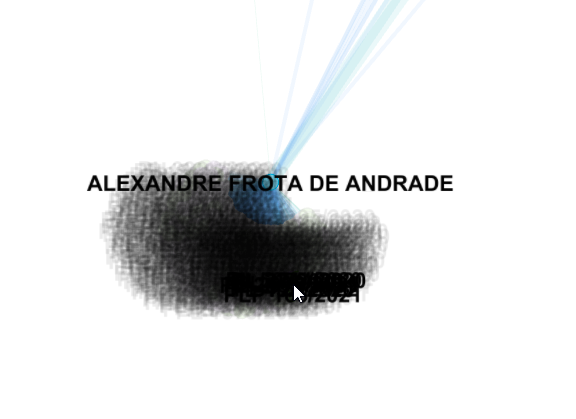

Vamos construir um grafo de colaborações. Faremos uma projeção do grafo bipartido, mantendo apenas os vértices de autores. Cada par de vértices de autores terá uma aresta se e somente se os autores tiverem ao menos uma proposição. O peso das arestas será a soma dos scores das proposições que os autores tiverem em comum, fracionadas entre os membros de cada proposição.

```
Partimos do grafo G(V,E) do principal componente conexo.

V_A := {v para todo v em V que seja de autores}
V_P := {v para todo v em V que seja de proposições}
E_A := {(u, v) com peso 0 para cada par u, v em V_A}

Para cada e := (u_a, v_a) em E_A:
    V_P' := {v_p para todo v_p in V_P tal que u_a, v_a sejam ambos autores de V_P}
    para cada v_p em V_P':
        n_v_p := (o número total de autores de v_p)
        e.peso := e.peso + v_p.score / n_v_p
```



Implementamos isso abaixo:

In [168]:
bill_nodes_df = node_main_df.join(edge_main_df.groupby('to').agg(
    n_authors=('from', 'count'),
    authors=('from', set)
),
    on="name",
    how="inner",
)
bill_nodes_df = bill_nodes_df[
    bill_nodes_df['n_authors'].gt(1)
]

bill_nodes_df[['score', 'n_authors', 'authors']].isna().any()
bill_nodes_df['score_share'] = bill_nodes_df['score'] / bill_nodes_df['n_authors']

In [169]:
authorship_edges = defaultdict(float)
authorship_nodes = set()

for index, row in bill_nodes_df.iterrows():
    score_share = row['score']
    for a1, a2 in itertools.pairwise(row['authors']):
        edge_key = tuple(sorted([a1, a2]))
        authorship_nodes.update(edge_key)
        authorship_edges[edge_key] += score_share
        
authorship_edges

defaultdict(float,
            {('CD:160541', 'CD:178879'): 1.0,
             ('CD:160541', 'CD:178975'): 1.0,
             ('CD:143632', 'CD:178975'): 1.0,
             ('CD:156190', 'CD:204365'): 1.5,
             ('CD:156190', 'CD:204461'): 4.25,
             ('CD:204461', 'CD:204528'): 5.5,
             ('CD:204523', 'CD:204528'): 5.5,
             ('CD:204516', 'CD:204523'): 4.75,
             ('CD:204516', 'CD:204532'): 5.25,
             ('CD:204519', 'CD:204532'): 7.0,
             ('CD:160518', 'CD:178927'): 2.25,
             ('CD:204508', 'CD:205535'): 0.25,
             ('CD:178989', 'CO:100292'): 3.0,
             ('CD:204442', 'CD:204546'): 0.25,
             ('CD:178947', 'CD:204442'): 0.5,
             ('CD:178947', 'CD:204462'): 1.0,
             ('CD:204376', 'CD:204462'): 0.5,
             ('CD:204374', 'CD:204376'): 2.0,
             ('CD:204374', 'CD:204507'): 3.75,
             ('CD:204507', 'CD:204545'): 2.5,
             ('CD:204449', 'CD:204545'): 0.25,
       

In [170]:
collab_node_df = node_main_df[node_main_df['name'].isin(authorship_nodes)].drop(['score', 'bigtype', 'billtype', 'score_label'], axis=1)
collab_node_df

,name,label,partido,type,cod_partido,uf,ideol_partido,regiao
25596,CD:66828,FAUSTO RUY PINATO,PP/SP,Deputado,PP,SP,right,sudeste
25597,CD:73463,OSMAR JOSÉ SERRAGLIO,PP/PR,Deputado,PP,PR,right,sul
25598,CD:73472,GERVÁSIO JOSÉ DA SILVA,PSDB/SC,Deputado,PSDB,SC,centre,sul
25599,CD:73486,DARCI POMPEO DE MATTOS,PDT/RS,Deputado,PDT,RS,centre-left,sul
25600,CD:73545,EUSTÁQUIO LUCIANO ZICA,PT/SP,Deputado,PT,SP,centre-left,sudeste
...,...,...,...,...,...,...,...,...
27675,SS:6295,CARLOS HENRIQUE BAQUETA FÁVARO,PSD/MT,Senador,PSD,MT,centre,centro-oeste
27676,SE:7352398,CPI DA PANDEMIA,,Orgao,not_applicable,,none,none
27677,SE:55226,COMISSÃO DIRETORA,,Orgao,not_applicable,,none,none
27678,SE:3947422,COMISSÃO DE DIREITOS HUMANOS E LEGISLAÇÃO PART...,,Orgao,not_applicable,,none,none


In [171]:
collab_edge_df = pd.DataFrame([
    {'from': src, 'to': tgt, 'weight': wt}
    for (src, tgt), wt in authorship_edges.items()
])

Agora temos em `collab_node_df` e `collab_edge_df` um grafo conexo em que os autores são conectados por arestas indicando sua colaboração em projetos de lei em comum, sendo ponderadas pela performance acumulada conforme definido acima.

In [172]:
# Queremos que o grafo se mantenha conexo, então vamos adicionar um epsilon aos pesos
EPSILON = 1e-6
collab_edge_df['weight'] += EPSILON

In [173]:
collab_g = build_graph(collab_node_df, collab_edge_df)
ccs = collab_g.connected_components()
len(ccs)


1

In [174]:
betwn_scores_wtd = collab_g.betweenness(normalized=True, directed=False, weights=collab_g.es['weight'])

In [175]:
collab_g.vs['btwn'] = betwn_scores_wtd

In [176]:
collab_node_df = collab_node_df.join(pd.DataFrame({'name': collab_g.vs['name'], 'btwn': collab_g.vs['btwn']}).set_index('name', drop=True), on="name")
collab_node_df

,name,label,partido,type,cod_partido,uf,ideol_partido,regiao,btwn
25596,CD:66828,FAUSTO RUY PINATO,PP/SP,Deputado,PP,SP,right,sudeste,0.000002
25597,CD:73463,OSMAR JOSÉ SERRAGLIO,PP/PR,Deputado,PP,PR,right,sul,0.000002
25598,CD:73472,GERVÁSIO JOSÉ DA SILVA,PSDB/SC,Deputado,PSDB,SC,centre,sul,0.000000
25599,CD:73486,DARCI POMPEO DE MATTOS,PDT/RS,Deputado,PDT,RS,centre-left,sul,0.008461
25600,CD:73545,EUSTÁQUIO LUCIANO ZICA,PT/SP,Deputado,PT,SP,centre-left,sudeste,0.002058
...,...,...,...,...,...,...,...,...,...
27675,SS:6295,CARLOS HENRIQUE BAQUETA FÁVARO,PSD/MT,Senador,PSD,MT,centre,centro-oeste,0.000013
27676,SE:7352398,CPI DA PANDEMIA,,Orgao,not_applicable,,none,none,0.000000
27677,SE:55226,COMISSÃO DIRETORA,,Orgao,not_applicable,,none,none,0.000000
27678,SE:3947422,COMISSÃO DE DIREITOS HUMANOS E LEGISLAÇÃO PART...,,Orgao,not_applicable,,none,none,0.000000


Agora vamos procurar comunidades dentro do grafo. Vamos começar pelo grafo inteiro.

In [177]:
collab_g.vs['leiden_mod_all'] = collab_g.community_leiden("modularity", weights="weight").membership

Mas quem são essas comunidades? Vamos analisar.

In [178]:
collab_node_df = collab_node_df.join(pd.DataFrame({'name': collab_g.vs['name'], 'leiden_mod_all': collab_g.vs['leiden_mod_all']}).set_index('name', drop=True), on="name")
collab_node_df

,name,label,partido,type,cod_partido,uf,ideol_partido,regiao,btwn,leiden_mod_all
25596,CD:66828,FAUSTO RUY PINATO,PP/SP,Deputado,PP,SP,right,sudeste,0.000002,0
25597,CD:73463,OSMAR JOSÉ SERRAGLIO,PP/PR,Deputado,PP,PR,right,sul,0.000002,0
25598,CD:73472,GERVÁSIO JOSÉ DA SILVA,PSDB/SC,Deputado,PSDB,SC,centre,sul,0.000000,6
25599,CD:73486,DARCI POMPEO DE MATTOS,PDT/RS,Deputado,PDT,RS,centre-left,sul,0.008461,0
25600,CD:73545,EUSTÁQUIO LUCIANO ZICA,PT/SP,Deputado,PT,SP,centre-left,sudeste,0.002058,10
...,...,...,...,...,...,...,...,...,...,...
27675,SS:6295,CARLOS HENRIQUE BAQUETA FÁVARO,PSD/MT,Senador,PSD,MT,centre,centro-oeste,0.000013,7
27676,SE:7352398,CPI DA PANDEMIA,,Orgao,not_applicable,,none,none,0.000000,7
27677,SE:55226,COMISSÃO DIRETORA,,Orgao,not_applicable,,none,none,0.000000,7
27678,SE:3947422,COMISSÃO DE DIREITOS HUMANOS E LEGISLAÇÃO PART...,,Orgao,not_applicable,,none,none,0.000000,7


In [179]:
collab_node_df.groupby('leiden_mod_all').agg(
    size=('leiden_mod_all', 'size'),
    author_type=('type', lambda x: x.value_counts().to_dict()),
    party=('cod_partido', lambda x: x.value_counts().to_dict()),
    ideology=('ideol_partido', lambda x: x.value_counts().to_dict()),
    region=('regiao', lambda x: x.value_counts().to_dict()),
    state=('uf', lambda x: x.value_counts().to_dict()),
).sort_values('size', ascending=False)

,size,author_type,party,ideology,region,state
leiden_mod_all,,,,,,
0,543,"{'Deputado': 538, 'Orgao': 4, 'Senador': 1}","{'PL': 100, 'UNIÃO': 64, 'PSD': 60, 'PP': 54, ...","{'centre': 149, 'far-right': 135, 'right': 132...","{'sudeste': 192, 'nordeste': 129, 'sul': 88, '...","{'SP': 79, 'MG': 53, 'RJ': 51, 'PR': 36, 'RS':..."
7,134,"{'Senador': 124, 'Deputado': 5, 'Orgao': 5}","{'MDB': 19, 'PSD': 18, 'PL': 17, 'PP': 14, 'PT...","{'centre': 46, 'centre-left': 23, 'right': 22,...","{'nordeste': 46, 'norte': 27, 'sudeste': 23, '...","{'SP': 8, 'MT': 8, 'CE': 8, 'AL': 7, 'ES': 6, ..."
6,84,{'Deputado': 84},"{'PSB': 34, 'PT': 9, 'MDB': 7, 'PDT': 6, 'PSDB...","{'centre-left': 50, 'centre': 19, 'centre-righ...","{'nordeste': 37, 'sudeste': 21, 'sul': 12, 'no...","{'PE': 12, 'BA': 8, 'SP': 7, 'RS': 6, 'MA': 5,..."
3,83,"{'Deputado': 82, 'Senador': 1}","{'PT': 32, 'PSOL': 19, 'MDB': 5, 'PP': 4, 'PDT...","{'centre-left': 39, 'left': 21, 'right': 8, 'c...","{'sudeste': 35, 'nordeste': 25, 'norte': 12, '...","{'RJ': 13, 'SP': 13, 'MG': 7, 'CE': 6, 'PI': 5..."
9,46,"{'Deputado': 45, 'Senador': 1}","{'PT': 15, 'PCdoB': 6, 'PDT': 4, 'MDB': 4, 'PP...","{'centre-left': 19, 'centre': 9, 'left': 6, 'r...","{'nordeste': 20, 'sudeste': 12, 'norte': 8, 's...","{'BA': 10, 'MG': 6, 'SP': 5, 'MA': 4, 'CE': 3,..."
1,35,{'Deputado': 35},"{'PT': 19, 'MDB': 3, 'PDT': 2, 'PP': 2, 'UNIÃO...","{'centre-left': 22, 'centre': 5, 'right': 3, '...","{'nordeste': 11, 'sudeste': 11, 'sul': 6, 'cen...","{'RJ': 4, 'CE': 4, 'PR': 3, 'RS': 3, 'MG': 3, ..."
8,25,{'Deputado': 25},"{'PT': 15, 'PSDB': 2, 'PSD': 2, 'DEM': 2, 'PL'...","{'centre-left': 16, 'centre': 6, 'centre-right...","{'nordeste': 12, 'sul': 5, 'sudeste': 5, 'cent...","{'PR': 3, 'RN': 2, 'BA': 2, 'MG': 2, 'CE': 2, ..."
10,15,{'Deputado': 15},"{'PT': 13, 'PMDB': 1, 'MDB': 1}","{'centre-left': 13, 'centre': 2}","{'sudeste': 6, 'nordeste': 5, 'sul': 3, 'centr...","{'SP': 3, 'BA': 3, 'SC': 3, 'ES': 2, 'MS': 1, ..."
2,2,{'Deputado': 2},"{'PSB': 1, 'PRB': 1}","{'centre-left': 1, 'right': 1}",{'nordeste': 2},{'BA': 2}


In [180]:
collab_g.write_graphml(str(ACCESS_DIR / "author_collab.graphml"))

In [181]:
collab_node_df.to_pickle(ACCESS_DIR / "collab_node_df.pkl")
collab_edge_df.to_pickle(ACCESS_DIR / "collab_edge_df.pkl")

In [182]:
collab_node_df = pd.read_pickle(ACCESS_DIR / "collab_node_df.pkl")
collab_edge_df = pd.read_pickle(ACCESS_DIR / "collab_edge_df.pkl")

In [183]:
collab_edge_df

,from,to,weight
0,CD:160541,CD:178879,1.000001
1,CD:160541,CD:178975,1.000001
2,CD:143632,CD:178975,1.000001
3,CD:156190,CD:204365,1.500001
4,CD:156190,CD:204461,4.250001
...,...,...,...
7768,SS:5070,SS:5502,0.250001
7769,SS:3806,SS:5672,0.250001
7770,SS:5793,SS:5894,0.250001
7771,SS:6009,SS:6340,0.250001


Notamos que uma das comunidades agrega todo o Senado, praticamente. Vamos separar entre as casas e continuar na próxima seção.

In [184]:
collab_cut_edge_df = collab_edge_df[collab_edge_df.apply(
    lambda row: row['from'][:2] == row['to'][:2],
    axis=1
)]
collab_cut_edge_df

,from,to,weight
0,CD:160541,CD:178879,1.000001
1,CD:160541,CD:178975,1.000001
2,CD:143632,CD:178975,1.000001
3,CD:156190,CD:204365,1.500001
4,CD:156190,CD:204461,4.250001
...,...,...,...
7768,SS:5070,SS:5502,0.250001
7769,SS:3806,SS:5672,0.250001
7770,SS:5793,SS:5894,0.250001
7771,SS:6009,SS:6340,0.250001


In [185]:
collab_node_df

,name,label,partido,type,cod_partido,uf,ideol_partido,regiao,btwn,leiden_mod_all
25596,CD:66828,FAUSTO RUY PINATO,PP/SP,Deputado,PP,SP,right,sudeste,0.000002,0
25597,CD:73463,OSMAR JOSÉ SERRAGLIO,PP/PR,Deputado,PP,PR,right,sul,0.000002,0
25598,CD:73472,GERVÁSIO JOSÉ DA SILVA,PSDB/SC,Deputado,PSDB,SC,centre,sul,0.000000,6
25599,CD:73486,DARCI POMPEO DE MATTOS,PDT/RS,Deputado,PDT,RS,centre-left,sul,0.008461,0
25600,CD:73545,EUSTÁQUIO LUCIANO ZICA,PT/SP,Deputado,PT,SP,centre-left,sudeste,0.002058,10
...,...,...,...,...,...,...,...,...,...,...
27675,SS:6295,CARLOS HENRIQUE BAQUETA FÁVARO,PSD/MT,Senador,PSD,MT,centre,centro-oeste,0.000013,7
27676,SE:7352398,CPI DA PANDEMIA,,Orgao,not_applicable,,none,none,0.000000,7
27677,SE:55226,COMISSÃO DIRETORA,,Orgao,not_applicable,,none,none,0.000000,7
27678,SE:3947422,COMISSÃO DE DIREITOS HUMANOS E LEGISLAÇÃO PART...,,Orgao,not_applicable,,none,none,0.000000,7


In [186]:
collab_cut_node_df = collab_node_df[
    collab_node_df['name'].isin(collab_edge_df['from'])
    | collab_node_df['name'].isin(collab_edge_df['to'])
]
collab_cut_node_df

,name,label,partido,type,cod_partido,uf,ideol_partido,regiao,btwn,leiden_mod_all
25596,CD:66828,FAUSTO RUY PINATO,PP/SP,Deputado,PP,SP,right,sudeste,0.000002,0
25597,CD:73463,OSMAR JOSÉ SERRAGLIO,PP/PR,Deputado,PP,PR,right,sul,0.000002,0
25598,CD:73472,GERVÁSIO JOSÉ DA SILVA,PSDB/SC,Deputado,PSDB,SC,centre,sul,0.000000,6
25599,CD:73486,DARCI POMPEO DE MATTOS,PDT/RS,Deputado,PDT,RS,centre-left,sul,0.008461,0
25600,CD:73545,EUSTÁQUIO LUCIANO ZICA,PT/SP,Deputado,PT,SP,centre-left,sudeste,0.002058,10
...,...,...,...,...,...,...,...,...,...,...
27675,SS:6295,CARLOS HENRIQUE BAQUETA FÁVARO,PSD/MT,Senador,PSD,MT,centre,centro-oeste,0.000013,7
27676,SE:7352398,CPI DA PANDEMIA,,Orgao,not_applicable,,none,none,0.000000,7
27677,SE:55226,COMISSÃO DIRETORA,,Orgao,not_applicable,,none,none,0.000000,7
27678,SE:3947422,COMISSÃO DE DIREITOS HUMANOS E LEGISLAÇÃO PART...,,Orgao,not_applicable,,none,none,0.000000,7


In [187]:
collab_cut_node_df.to_pickle(ACCESS_DIR / "collab_cut_node_df.pkl")
collab_cut_edge_df.to_pickle(ACCESS_DIR / "collab_cut_edge_df.pkl")

In [188]:
cut_g = build_graph(collab_cut_node_df, collab_cut_edge_df)


In [189]:
cut_g.write_graphml(str(ACCESS_DIR / "author_cut_collab.graphml"))

In [190]:
collab_node_df

,name,label,partido,type,cod_partido,uf,ideol_partido,regiao,btwn,leiden_mod_all
25596,CD:66828,FAUSTO RUY PINATO,PP/SP,Deputado,PP,SP,right,sudeste,0.000002,0
25597,CD:73463,OSMAR JOSÉ SERRAGLIO,PP/PR,Deputado,PP,PR,right,sul,0.000002,0
25598,CD:73472,GERVÁSIO JOSÉ DA SILVA,PSDB/SC,Deputado,PSDB,SC,centre,sul,0.000000,6
25599,CD:73486,DARCI POMPEO DE MATTOS,PDT/RS,Deputado,PDT,RS,centre-left,sul,0.008461,0
25600,CD:73545,EUSTÁQUIO LUCIANO ZICA,PT/SP,Deputado,PT,SP,centre-left,sudeste,0.002058,10
...,...,...,...,...,...,...,...,...,...,...
27675,SS:6295,CARLOS HENRIQUE BAQUETA FÁVARO,PSD/MT,Senador,PSD,MT,centre,centro-oeste,0.000013,7
27676,SE:7352398,CPI DA PANDEMIA,,Orgao,not_applicable,,none,none,0.000000,7
27677,SE:55226,COMISSÃO DIRETORA,,Orgao,not_applicable,,none,none,0.000000,7
27678,SE:3947422,COMISSÃO DE DIREITOS HUMANOS E LEGISLAÇÃO PART...,,Orgao,not_applicable,,none,none,0.000000,7
